In [505]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [506]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro,ET0
time,,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18,36.289050
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14,24.390254
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60,60.468354
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15,56.266438
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78,0.986866


In [507]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
ET0                        0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

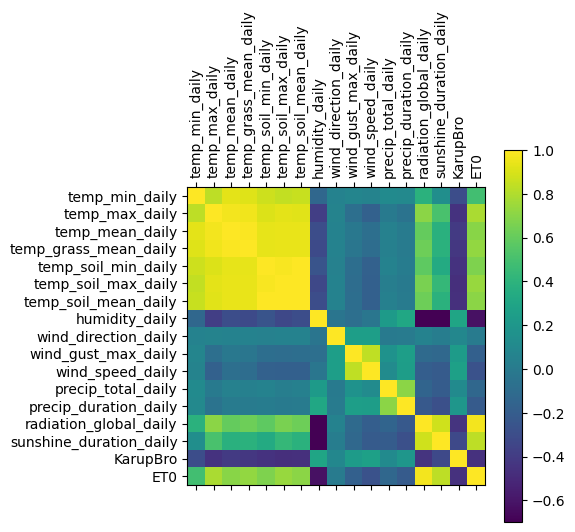

In [508]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

In [509]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

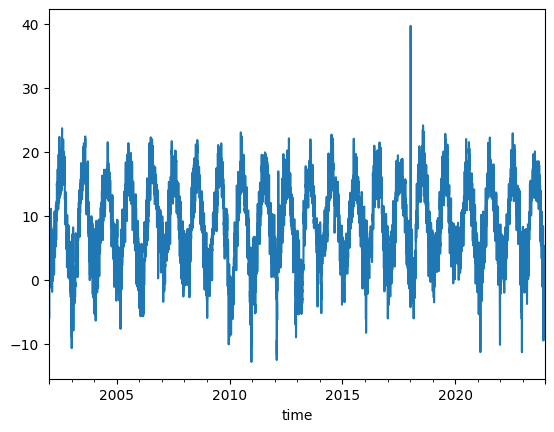

In [510]:
temp = df['temp_mean_daily']
temp.plot()

In [511]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

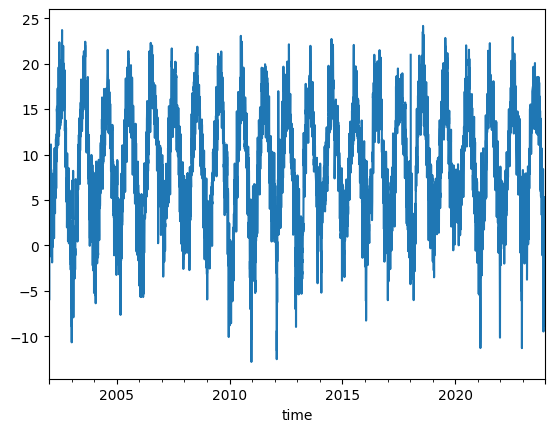

In [512]:
temp.plot()

<Axes: xlabel='time'>

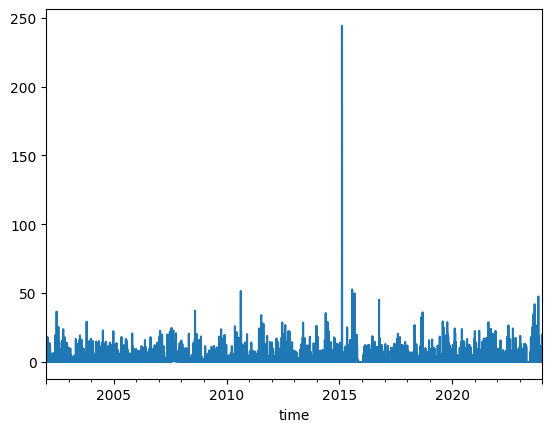

In [513]:
rain = df['precip_total_daily']
rain.plot()

In [514]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

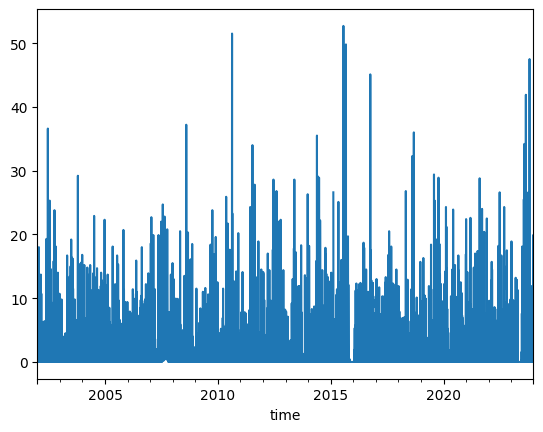

In [515]:
rain.plot()

<Axes: xlabel='time'>

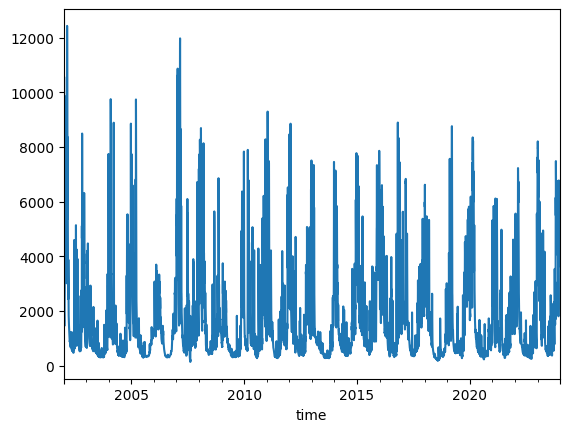

In [516]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [517]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-20,4448.18,1.703030e+09
2023-12-21,5602.14,1.703117e+09
2023-12-22,6636.60,1.703203e+09


In [518]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
# inflow_df['PET'] = df['ET0']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-20,4448.18,0.4,3.141667,-0.206570,0.978432
2023-12-21,5602.14,19.9,5.316667,-0.189708,0.981841
2023-12-22,6636.60,0.6,2.395833,-0.172790,0.984959


In [519]:
import numpy as np

HORIZON = 1
WINDOW = 5
EXOS = ['Rain', 'Temp', 'Year sin', 'Year cos']
# EXOS = ['Rain', 'Temp', 'PET' ,'Year sin', 'Year cos']

def df_to_X_y_multi_step_exo(df, window_size=WINDOW, horizon=HORIZON, 
                               inflow_col='Inflow', 
                               exo_cols=EXOS):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.
    
    Parameters:
      df: DataFrame containing the data.
      window_size: Number of past days used as input.
      horizon: Forecast length (number of days ahead).
      inflow_col: Name of the target variable column.
      exo_cols: List of column names to use as exogenous features.
                If None, defaults to all columns except the target.
                
    Returns:
      X : np.array with shape (num_samples, window_size, num_features + len(exo_cols)*horizon)
          For each sample, the historical window is stored in the first 'num_features' columns,
          and the forecast exogenous data for the next 'horizon' days is appended to the last row.
      y : np.array with shape (num_samples, horizon)
          The target inflow values for the next 'horizon' days.
    """
    # If no exogenous columns provided, use all columns except the inflow
    if exo_cols is None:
        exo_cols = [col for col in df.columns if col != inflow_col]
    
    # Convert DataFrame to numpy array
    data = df.to_numpy()  # shape: (total_days, num_features)
    num_features = data.shape[1]
    
    # Determine the column indices for the inflow and exogenous features
    col_names = list(df.columns)
    inflow_idx = col_names.index(inflow_col)
    exo_indices = [col_names.index(col) for col in exo_cols]
    
    X, y = [], []
    n = len(data)
    
    # Loop over possible starting indices for the forecast window
    for i in range(n - window_size - horizon + 1):
        # 1) Historical window: take all features for the past 'window_size' days.
        hist_window = data[i : i + window_size, :]
        
        # 2) Future exogenous features: take the specified exo features for the next 'horizon' days.
        exo_future = data[i + window_size : i + window_size + horizon, :][:, exo_indices]
        
        # 3) Build a sample matrix: start with historical data and then append forecast exo features in the last row.
        sample = np.zeros((window_size, num_features + len(exo_cols) * horizon))
        sample[:, :num_features] = hist_window
        
        # Append each day's exogenous data into the extra columns of the last row.
        for day_idx in range(horizon):
            start_col = num_features + day_idx * len(exo_cols)
            end_col = start_col + len(exo_cols)
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days.
        future_inflow = data[i + window_size : i + window_size + horizon, inflow_idx]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [520]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8023, 5, 9), (8023, 1))

In [521]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 9), (6000, 1), (1000, 5, 9), (1000, 1), (1023, 5, 9), (1023, 1))

### Preprocessing

In [522]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# PET_training_mean = np.mean(X2_train[:, :, 3])
# PET_training_std = np.std(X2_train[:, :, 3])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    # X[:, :, 3] = (X[:, :, 3] - PET_training_mean) / PET_training_std
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-0.38355823],
       [-0.44990893],
       [-0.47533252],
       ...,
       [ 3.00218845],
       [ 2.50380534],
       [ 2.13556981]])

In [523]:
(len(EXOS)+1)+len(EXOS)*HORIZON

9

In [524]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

model4 = Sequential()
model4.add(InputLayer(input_shape=(WINDOW, (len(EXOS)+1)+len(EXOS)*HORIZON)))  # (window_size, 5 + 4*horizon)
model4.add(LSTM(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
# Output 3 values at once (for 3-day forecast)
model4.add(Dense(HORIZON, activation='linear'))

model4.compile(optimizer='adam', loss='mse')
model4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                18944     
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [525]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [526]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
173/188 [==========================>...] - ETA: 0s - loss: 0.7926 - root_mean_squared_error: 0.8903INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.7688 - root_mean_squared_error: 0.8768 - val_loss: 0.4185 - val_root_mean_squared_error: 0.6469
Epoch 2/100
166/188 [=========================>....] - ETA: 0s - loss: 0.3159 - root_mean_squared_error: 0.5621INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.3099 - root_mean_squared_error: 0.5567 - val_loss: 0.1692 - val_root_mean_squared_error: 0.4113
Epoch 3/100
172/188 [==========================>...] - ETA: 0s - loss: 0.2114 - root_mean_squared_error: 0.4597INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.2068 - root_mean_squared_error: 0.4547 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3273
Epoch 4/100
188/188 [==============================] - ETA: 0s - loss: 0.1587 - root_mean_squared_error: 0.3984INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1587 - root_mean_squared_error: 0.3984 - val_loss: 0.0755 - val_root_mean_squared_error: 0.2748
Epoch 5/100
178/188 [===========================>..] - ETA: 0s - loss: 0.1308 - root_mean_squared_error: 0.3617INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1311 - root_mean_squared_error: 0.3620 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
Epoch 6/100
169/188 [=========================>....] - ETA: 0s - loss: 0.1154 - root_mean_squared_error: 0.3397INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1140 - root_mean_squared_error: 0.3376 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474
Epoch 7/100
176/188 [===========================>..] - ETA: 0s - loss: 0.1022 - root_mean_squared_error: 0.3196INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1026 - root_mean_squared_error: 0.3203 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 8/100
157/188 [========================>.....] - ETA: 0s - loss: 0.1005 - root_mean_squared_error: 0.3169INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0947 - root_mean_squared_error: 0.3077 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2172
Epoch 9/100
166/188 [=========================>....] - ETA: 0s - loss: 0.0875 - root_mean_squared_error: 0.2959INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.0882 - root_mean_squared_error: 0.2969 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 10/100
180/188 [===========================>..] - ETA: 0s - loss: 0.0832 - root_mean_squared_error: 0.2885INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0835 - root_mean_squared_error: 0.2889 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1956
Epoch 11/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0789 - root_mean_squared_error: 0.2808 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0752 - root_mean_squared_error: 0.2742 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2001
Epoch 13/100
179/188 [===========================>..] - ETA: 0s - loss: 0.0711 - root_mean_squared_error: 0.2666INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0720 - root_mean_squared_error: 0.2684 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1912
Epoch 14/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0696 - root_mean_squared_error: 0.2638 - val_loss: 0.0400 - val_root_mean_squared_error: 0.1999
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0674 - root_mean_squared_error: 0.2597 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2013
Epoch 16/100
167/188 [=========================>....] - ETA: 0s - loss: 0.0668 - root_mean_squared_error: 0.2585INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0658 - root_mean_squared_error: 0.2565 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1856
Epoch 17/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1985
Epoch 18/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0628 - root_mean_squared_error: 0.2507 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1887
Epoch 19/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 20/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0611 - root_mean_squared_error: 0.2472 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 21/100
173/188 [==========================>...] - ETA: 0s - loss: 0.0603 - root_mean_squared_error: 0.2456INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0596 - root_mean_squared_error: 0.2441 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 22/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0589 - root_mean_squared_error: 0.2427 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 23/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0580 - root_mean_squared_error: 0.2407 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1800
Epoch 24/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 25/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0569 - root_mean_squared_error: 0.2386 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 26/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.0371 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0539 - root_mean_squared_error: 0.2323 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1743
Epoch 33/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 34/100
176/188 [===========================>..] - ETA: 0s - loss: 0.0541 - root_mean_squared_error: 0.2326INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0530 - root_mean_squared_error: 0.2303 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 35/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 36/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1789
Epoch 37/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 38/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0519 - root_mean_squared_error: 0.2279 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1908
Epoch 39/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0418 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 9ms/step - loss: 0.0505 - root_mean_squared_error: 0.2248 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 45/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0499 - root_mean_squared_error: 0.2233 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1715
Epoch 46/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1786
Epoch 47/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0500 - root_mean_squared_error: 0.2235 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 48/100
163/188 [=========================>....] - ETA: 0s - loss: 0.0527 - root_mean_squared_error: 0.2295INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 49/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1718
Epoch 50/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1964
Epoch 51/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1772
Epoch 52/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1701
Epoch 53/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0483 - root_mean_squared_error: 0.2199 - val_loss: 0.0340 - val_r

In [527]:
def postprocess(arr):
    # Apply the inverse transformation to all elements in the array
    return (arr * inflow_training_std) + inflow_training_mean

def get_predictions_postprocessed(model, X, y):
    # Get multi-step predictions from the model (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Postprocess predictions and actuals
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted (e.g., 3)
    horizon = predictions_post.shape[1]
    
    # Create a dictionary with columns for each forecast day
    data = {}
    for i in range(horizon):
        data[f'Day {i+1} Pred'] = predictions_post[:, i]
        data[f'Day {i+1} Actual'] = y_post[:, i]
    
    # Create and return a DataFrame with the results
    return pd.DataFrame(data)

# Example usage:
post_processed_df = get_predictions_postprocessed(model4, X2_test, y2_test)
post_processed_df

32/32 [==============================] - 0s 713us/step


,Day 1 Pred,Day 1 Actual
0,1103.584229,1015.35
1,1102.747192,905.19
2,1011.836243,862.98
3,818.009338,832.00
4,2676.479492,3217.89
...,...,...
1018,3657.871582,4448.18
1019,5399.497070,5602.14
1020,8044.449219,6636.60
1021,5211.208008,5809.15


In [528]:
def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon using the rmse package/function.

    Parameters:
      df      : DataFrame with columns 
                'Inflow Predictions Day 1', 'Inflow Actuals Day 1', 
                'Inflow Predictions Day 2', 'Inflow Actuals Day 2', etc.
      horizon : Number of forecast days (e.g., 3)

    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Day {i} Pred'
        actual_col = f'Day {i} Actual'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
rmse_values


{'Day 1': 363.12374684840796}

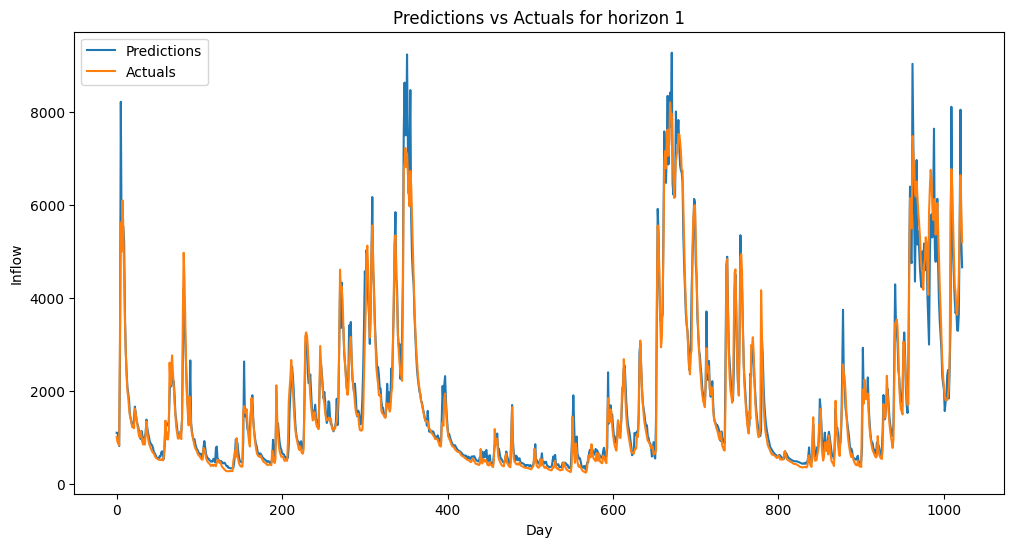

In [529]:
plt.figure(figsize=(12, 6))
plt.plot(post_processed_df['Day 1 Pred'], label='Predictions')
plt.plot(post_processed_df['Day 1 Actual'], label='Actuals')
plt.xlabel('Day')
plt.ylabel('Inflow')
plt.title("Predictions vs Actuals for horizon 1")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

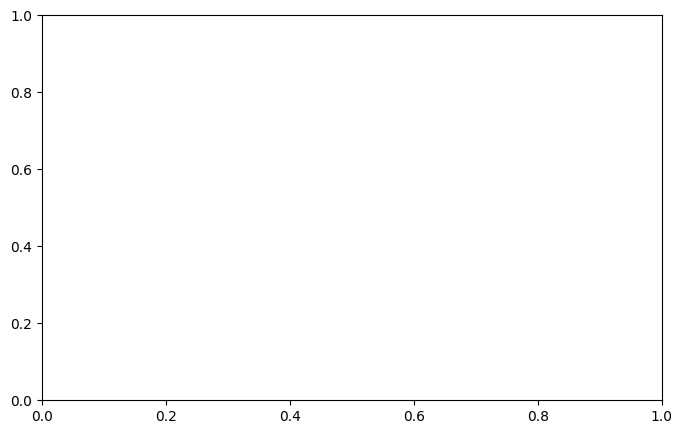

In [530]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()

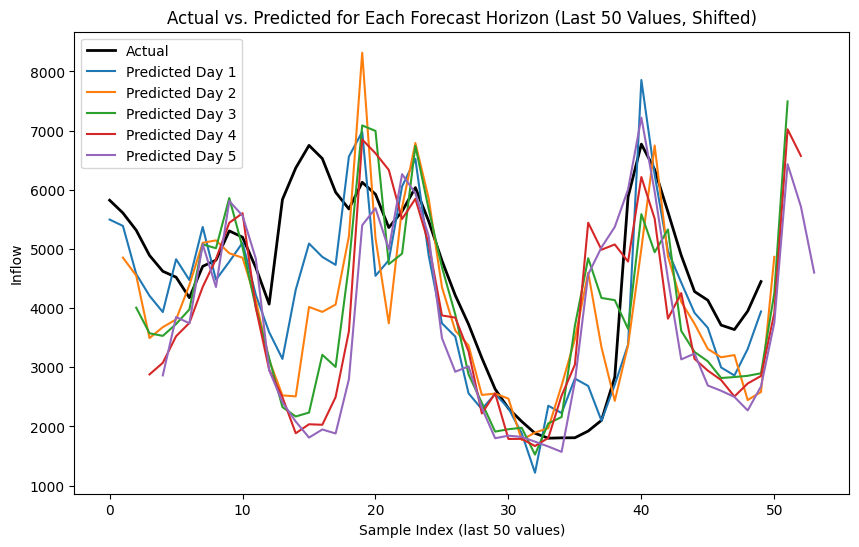

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_horizon_single_actual_shifted(df, horizon=HORIZON, last_n=50):
    """
    Plots one actual line (since all horizons share the same actual values)
    and the predicted values for each forecast horizon on a single figure,
    using only the last 'last_n' samples, but SHIFTING each horizon's line
    so it aligns with the actual day it predicts.

    Assumes the DataFrame has:
      - An actual column named "Day 1 Actual"
      - Predicted columns for each horizon: "Day 1 Pred", "Day 2 Pred", ..., "Day k Pred"

    Parameters:
      df      : DataFrame with at least these columns
      horizon : Number of forecast days (e.g., 5)
      last_n  : How many of the final samples to plot
    """
    plt.figure(figsize=(10, 6))

    # We'll create an x-array for the "last_n" points
    # Day 1 predictions align at x, Day 2 at x+1, Day 3 at x+2, etc.
    x = np.arange(last_n)

    # Plot only the last 'last_n' samples of the actual values
    actual = df["Day 1 Actual"].tail(last_n).values
    plt.plot(x, actual, label="Actual", color="black", linewidth=2)

    # Plot each horizon with a horizontal shift of (i - 1)
    for i in range(1, horizon + 1):
        pred_col = f"Day {i} Pred"
        preds = df[pred_col].tail(last_n).values

        # Shift Day i's predictions by (i-1) steps
        x_shifted = x + (i - 1)
        plt.plot(x_shifted, preds, label=f"Predicted Day {i}")

    plt.xlabel(f"Sample Index (last {last_n} values)")
    plt.ylabel("Inflow")
    plt.title(f"Actual vs. Predicted for Each Forecast Horizon (Last {last_n} Values, Shifted)")
    plt.legend()
    plt.show()

# Example usage:
plot_multi_horizon_single_actual_shifted(post_processed_df, horizon=HORIZON, last_n=50)

